### Notebook for generating prediciton masks over custom dataset.

### Assuming data setup as
```
road_connectivity
│
└───data
|    └───stratford
|                └───crops_700_600
|                                └───images
|                                └───pred_figures # created by script
|
|                
└───save
     └───dg_stak_mtl_24hours
                 └───model_best.pth.tar

```

Modify **data_dir**, **test_dataset**, **model_name**, **model_path** as required 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import json

from model.models import MODELS

In [4]:
data_dir = './data/stratford/'
test_dataset = 'crops_1300_1200'
saved_model = 'dg_stak_mtl_24hr_Normalize_SGD'

model_name = 'StackHourglassNetMTL'
model_path = './save/' + saved_model + '/model_best.pth.tar'

path_to_images = os.path.join(data_dir, test_dataset, 'images')
path_to_txt = os.path.join(data_dir, test_dataset, 'test_' + test_dataset + '.txt')

# save_results = os.path.join(data_dir, test_dataset, 'results')
save_pred_figures = os.path.join('./results', saved_model, test_dataset, 'pred_figures')
save_info_file = os.path.join('./results', saved_model, test_dataset,'info.txt')

# From config.json
config = {
    'mean' : [70.95016901, 71.16398124, 71.30953645],
    'std' : [34.00087859, 35.18201658, 36.40463264],
    'normalize_type': 'Mean',                          # <------------- Do modify with respect to training
    'task1_classes' : 2,
    'task2_classes' : 37,
    'model_name' : model_name,
    'model_path' : model_path,
    'path_to_images' : path_to_images
}

In [5]:
if not os.path.isdir(os.path.join('./results', saved_model)):
    os.mkdir(os.path.join('./results', saved_model))

if not os.path.isdir(os.path.join('./results', saved_model, test_dataset)):
    os.mkdir(os.path.join('./results', saved_model, test_dataset))
    
if not os.path.isdir(os.path.join('./results', saved_model, test_dataset, 'pred_figures')):
    os.mkdir(os.path.join('./results', saved_model, test_dataset, 'pred_figures'))

In [6]:
class test_dataset(Dataset):
    def __init__(self, path_txt, path_images, config):
        self.csv = pd.read_csv(path_txt, header = None)
        self.path_images = path_images
        self.config = config
        
    def __len__(self):
        return len(self.csv)
    
    def reshape(self,image):
    
        normalize_type = self.config['normalize_type']
        mean_bgr = self.config['mean']
        deviation_bgr = self.config['std']

        if normalize_type == "Std":
            image = (image - mean_bgr) / (np.multiply(3, deviation_bgr))
        elif normalize_type == "MinMax":
            image = (image - min_bgr) / (max_bgr - min_bgr)
            image = image * 2 - 1
        elif normalize_type == "Mean":
            image -= mean_bgr
        elif normalize_type == "Normalize":
            image = image / 255.0
        else:
            image = (image / 255.0) * 2 - 1

        image = image.transpose(2, 0, 1)
        return image
    
    def __getitem__(self, index):
        img_name = os.path.join(self.path_images, self.csv.iloc[index,0])
        imgBGR = cv2.imread(img_name)
        img = self.reshape(imgBGR.astype(float))
        return img, imgBGR, self.csv.iloc[index,0]

In [7]:
def cv2_to_plt(img):
    im_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return im_rgb

In [8]:
def save_figures(BGR_sample, outputs, img_name, save_path):

    sample_dim = BGR_sample.shape
    shp1 = outputs[1].shape
    shp2 = outputs[2].shape
    shp3 = outputs[3].shape

    for i in range(len(BGR_sample)):

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,5))
        fig.suptitle(img_name[i])

        ax1.imshow(cv2_to_plt(BGR_sample[i]))
        ax1.set_title('Input image, dim -> {} x {}'.format(sample_dim[1], sample_dim[2]))
        
        ax2.imshow((F.softmax(outputs[0].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
        ax2.set_title('Prediction on img size -> {} x {}'.format(shp1[2], shp1[3]))

        ax3.imshow((F.softmax(outputs[1].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
        ax3.set_title('Prediction on img size -> {} x {}'.format(shp1[2], shp1[3]))

        ax4.imshow((F.softmax(outputs[2].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
        ax4.set_title('Prediction on img size -> {} x {}'.format(shp2[2], shp2[3]))

        ax5.imshow((F.softmax(outputs[3].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
        ax5.set_title('Prediction on img size -> {} x {}'.format(shp3[2], shp3[3]))

        plt.savefig(os.path.join(save_path, img_name[i]))
        plt.close()


In [12]:
test_ds = test_dataset(path_to_txt, path_to_images, config)
test_loader =  DataLoader(test_ds, batch_size=2, num_workers=8, shuffle = True)

In [13]:
checkpoint = torch.load(model_path, 
                        map_location=torch.device('cpu'))

model = MODELS[model_name](
    config["task1_classes"], config["task2_classes"])

# original saved file with DataParallel
# create new OrderedDict that does not contain `module.`

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

# load params
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [14]:
if (torch.cuda.device_count() > 0):
    device = 'cuda:0'
else:
    device = 'cpu'

In [15]:
model.eval()

model.to(torch.device(device))
model = model

In [16]:
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        ip_sample, BGR_sample, img_name = sample
        outputs, pred_vecmaps = model(ip_sample.float().to(torch.device(device)))
        
        save_figures(BGR_sample, outputs, img_name, save_pred_figures)

with open(save_info_file, 'w') as file:
    file.write(json.dumps(config, indent = 2)) # indent = 2, each item of dict on new line
    file.close()

In [11]:
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        ip_sample, BGR_sample, img_name = sample
        outputs, pred_vecmaps = model(ip_sample.float().to(torch.device(device)))
        
        break

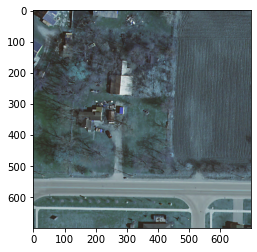

In [32]:
plt.imshow(BGR_sample[1])

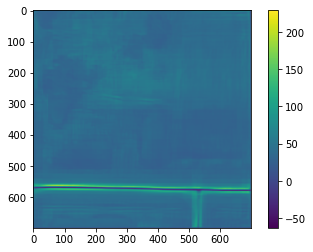

In [35]:
plt.imshow(outputs[3][1][0].cpu())
plt.colorbar()

In [28]:
pred_vecmaps[0].shape

torch.Size([8, 37, 175, 175])

In [13]:
len(pred_vecmaps)

4

In [14]:
pred_vecmaps[0].shape

torch.Size([4, 37, 175, 175])

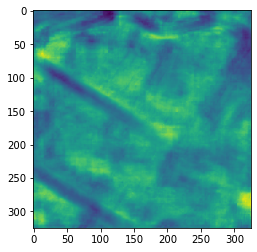

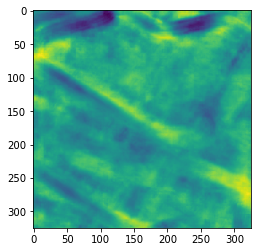

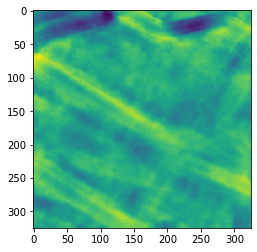

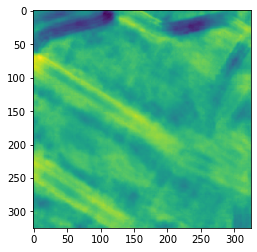

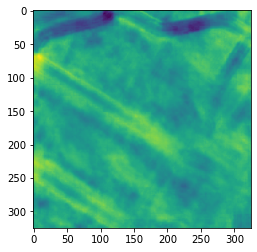

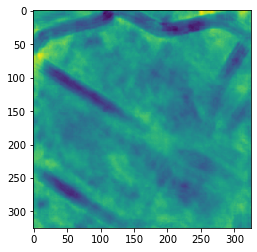

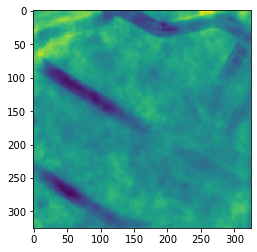

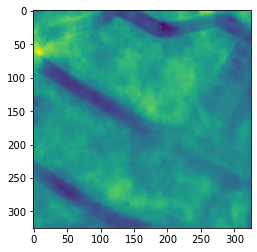

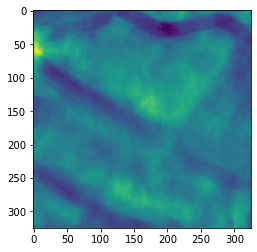

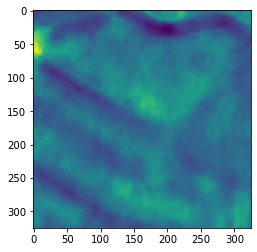

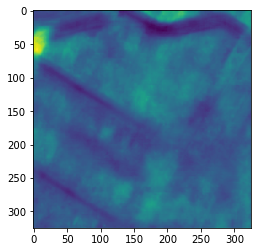

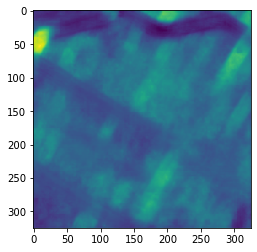

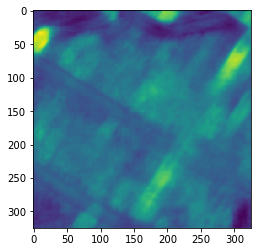

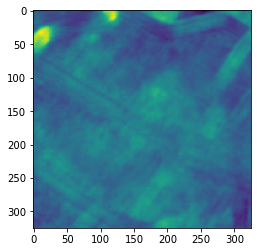

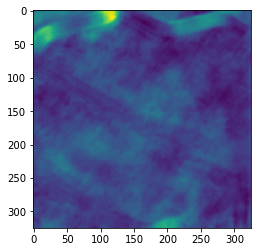

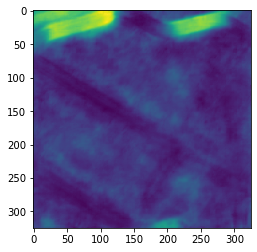

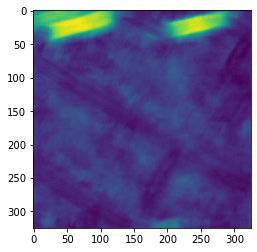

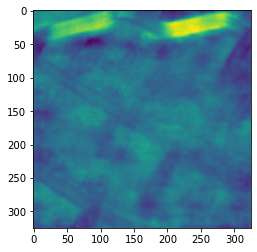

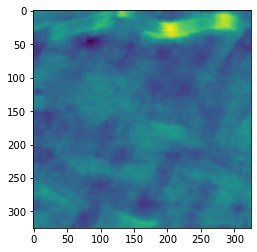

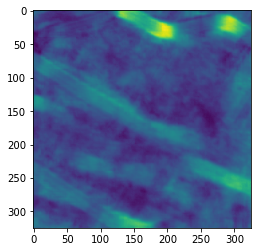

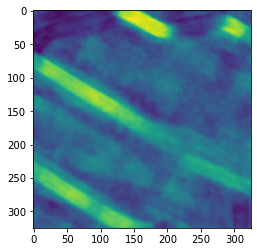

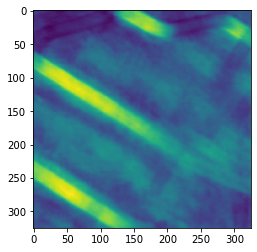

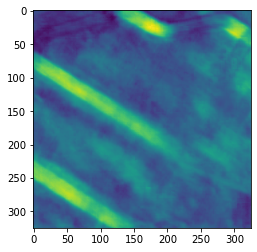

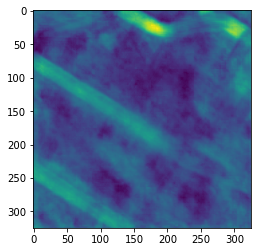

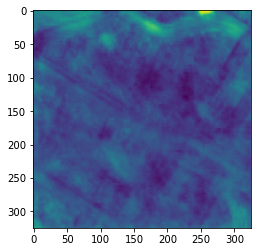

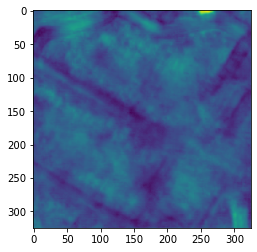

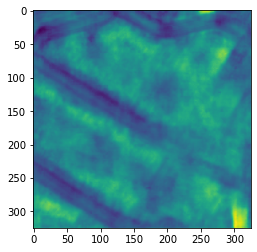

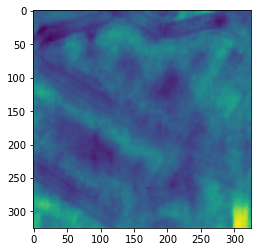

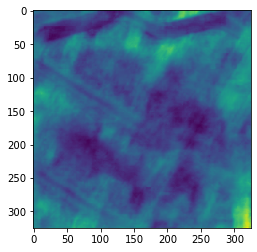

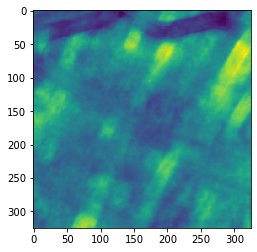

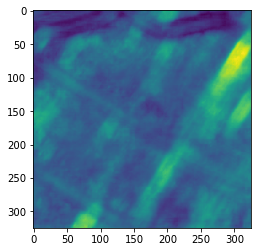

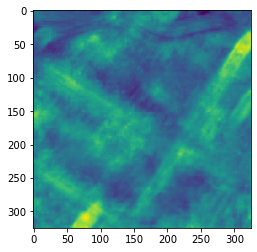

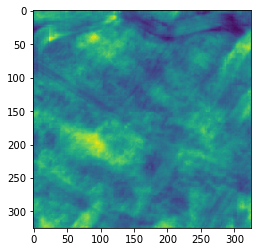

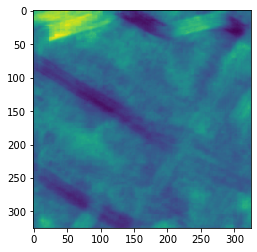

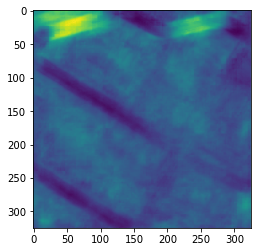

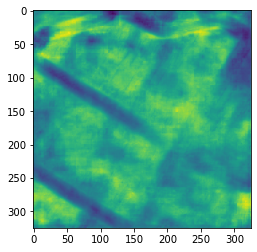

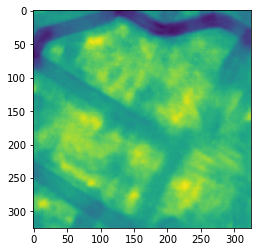

In [29]:
for i in range(37):
    plt.imshow(pred_vecmaps[1][0,i,:,:].cpu())
    plt.show()

In [27]:
outputs[0].shape

torch.Size([4, 2, 325, 325])

In [21]:
plt.imshow(F.softmax(outputs[0].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:].shape

torch.Size([175, 175])

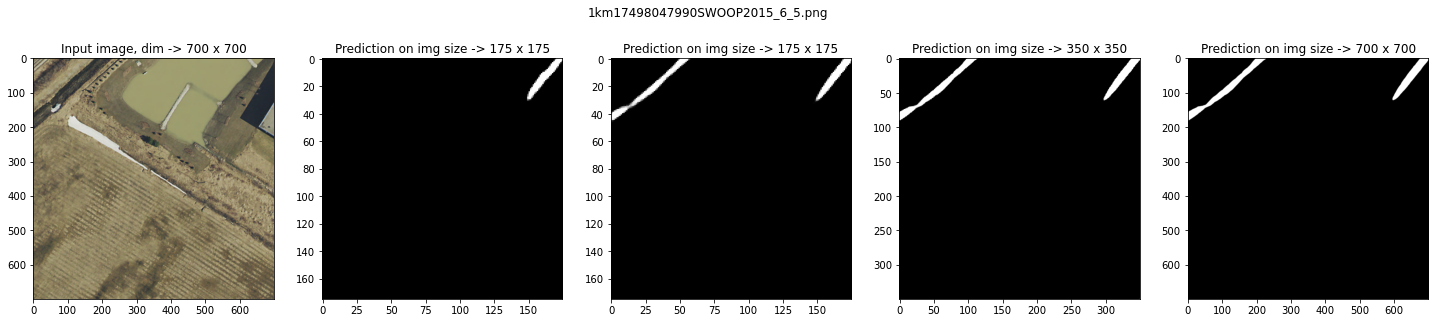

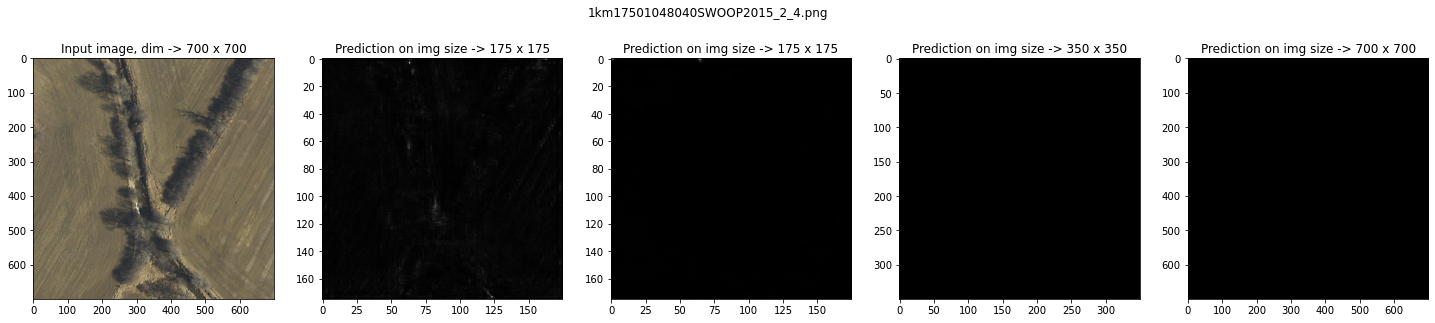

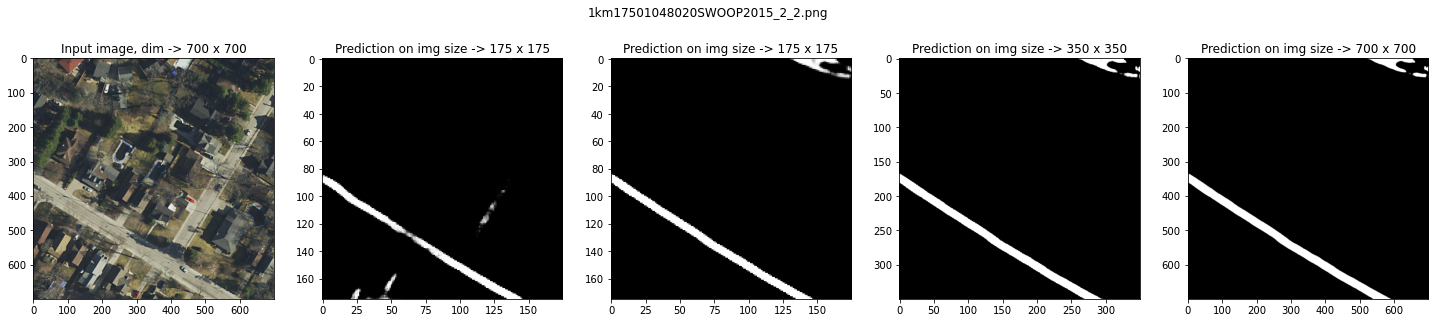

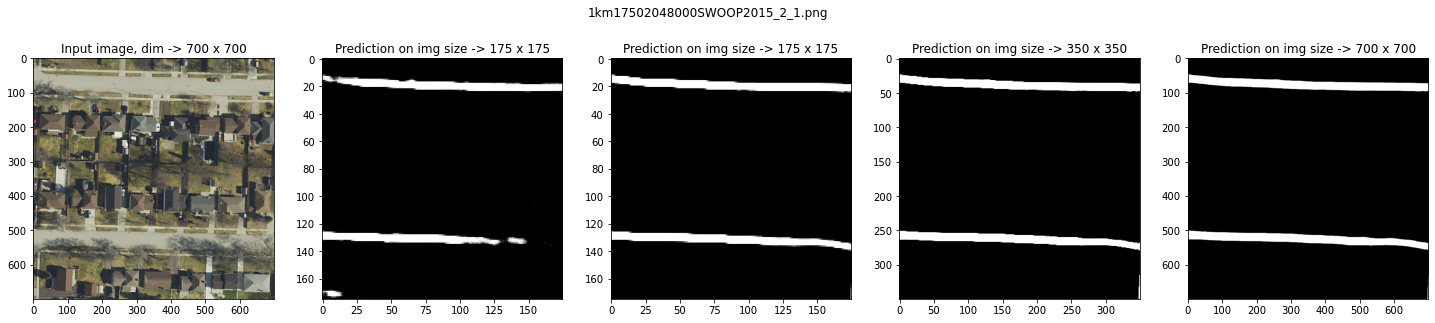

In [22]:
sample_dim = BGR_sample.shape
shp1 = outputs[1].shape
shp2 = outputs[2].shape
shp3 = outputs[3].shape

for i in range(len(BGR_sample)):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,5))
    fig.suptitle(img_name[i])

    ax1.imshow(cv2_to_plt(BGR_sample[i]))
    ax1.set_title('Input image, dim -> {} x {}'.format(sample_dim[1], sample_dim[2]))
    
    ax2.imshow((F.softmax(outputs[0].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
    ax2.set_title('Prediction on img size -> {} x {}'.format(shp1[2], shp1[3]))

    ax3.imshow((F.softmax(outputs[1].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
    ax3.set_title('Prediction on img size -> {} x {}'.format(shp1[2], shp1[3]))

    ax4.imshow((F.softmax(outputs[2].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
    ax4.set_title('Prediction on img size -> {} x {}'.format(shp2[2], shp2[3]))

    ax5.imshow((F.softmax(outputs[3].cpu(), dim=1).data.cpu()[:, 1, :, :])[i,:,:], cmap = 'gray')
    ax5.set_title('Prediction on img size -> {} x {}'.format(shp3[2], shp3[3]))

#     plt.savefig(os.path.join(save_path, img_name[i]))
    plt.show()

In [6]:
sample_dim = [700, 700]

for i in range(len(BGR_sample)):
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,25))

    ax1.imshow(cv2_to_plt(BGR_sample[i]))
    ax1.set_title('Input image, dim -> {} x {}'.format(sample_dim[0], sample_dim[1]))
    
    ax2.imshow((F.softmax(outputs[0], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax2.set_title('Prediction on size -> {} x {}'.format(325, 325))
    
    ax3.imshow((F.softmax(outputs[1], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax3.set_title('Prediction on size -> {} x {}'.format(325, 325))
    
    ax4.imshow((F.softmax(outputs[2], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax4.set_title('Prediction on size -> {} x {}'.format(650, 650))
    
    ax5.imshow((F.softmax(outputs[3], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax5.set_title('Prediction on size -> {} x {}'.format(1300, 1300))
    
    plt.show()

NameError: name 'BGR_sample' is not defined

In [ ]:
# def get_pred_op(outputs):
#     outputs_o = outputs[-1]
#     _, predicted_o = torch.max(outputs_o.data, 1)

#     idx = 1
#     predicted_s = (predicted_o[idx]).numpy() * 255.0
#     predicted_s = np.asarray(predicted_s, dtype=np.uint8)
#     predicted_s = np.stack((predicted_s,) * 3).transpose(1, 2, 0)
    
#     return predicted_s

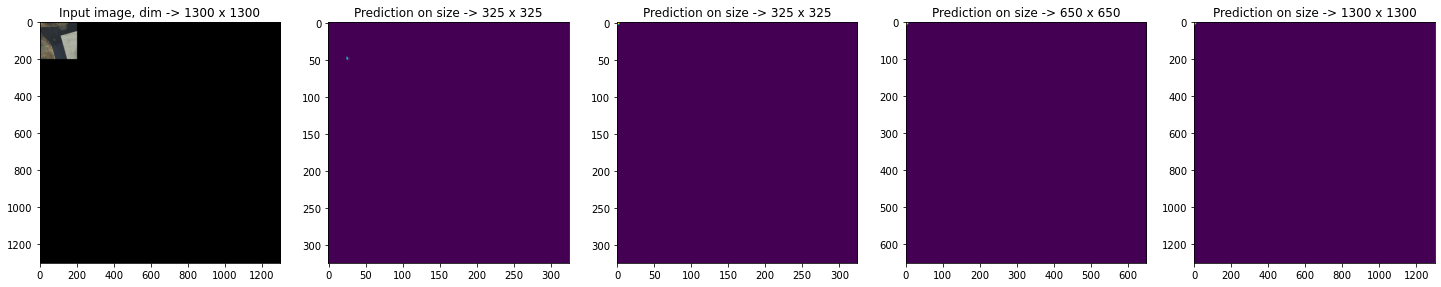

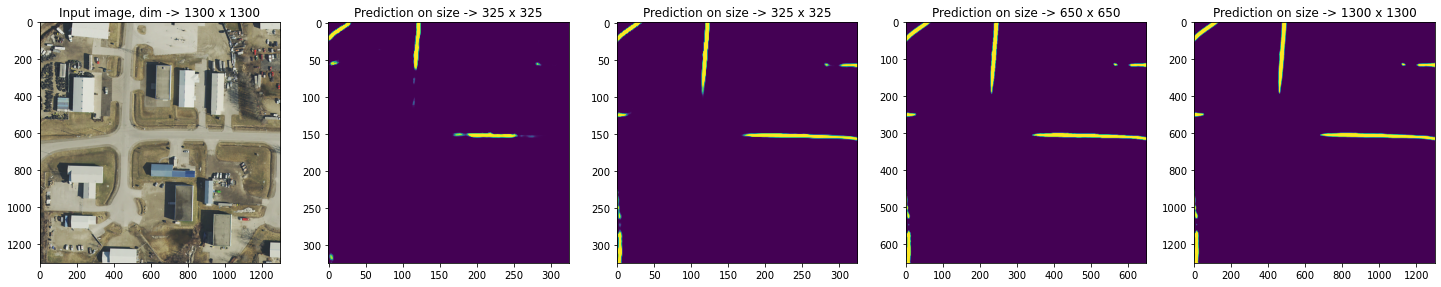

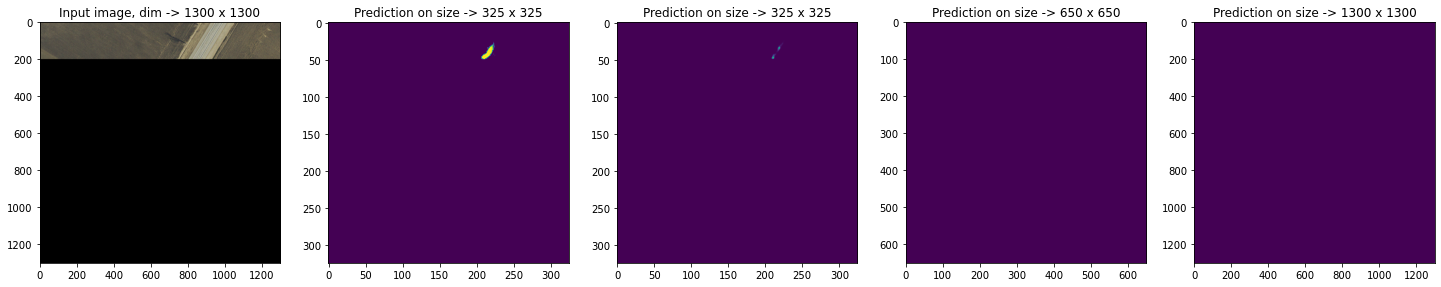

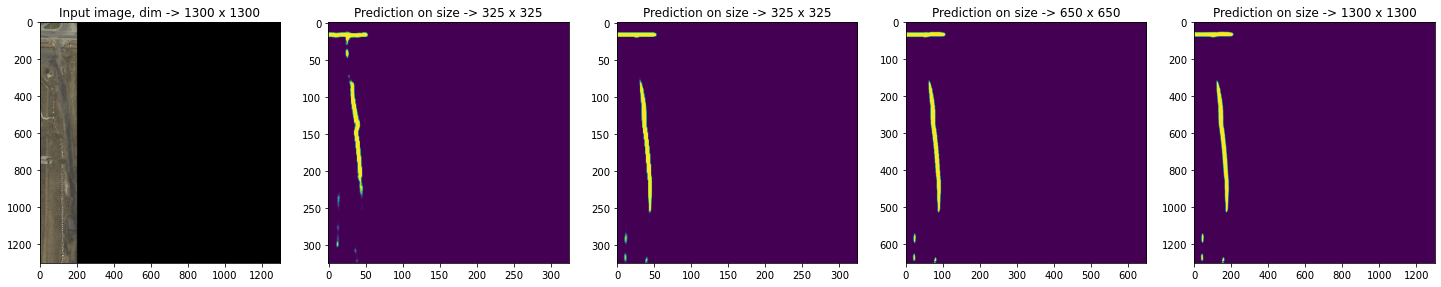

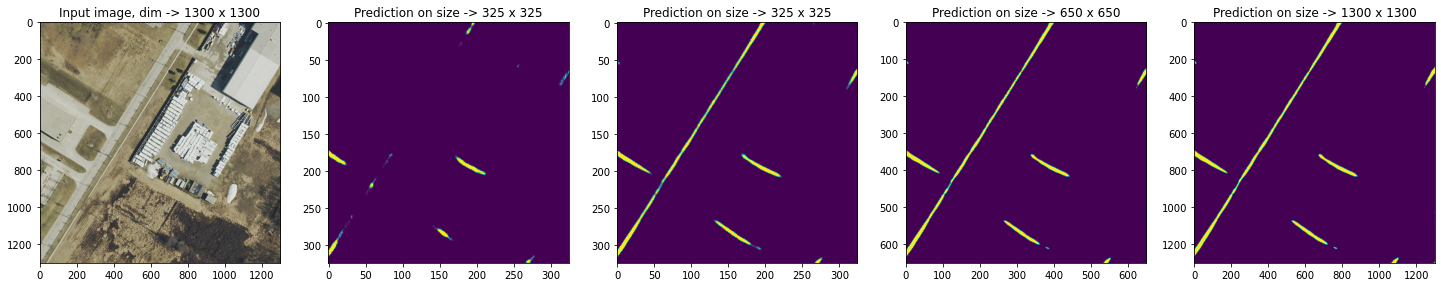

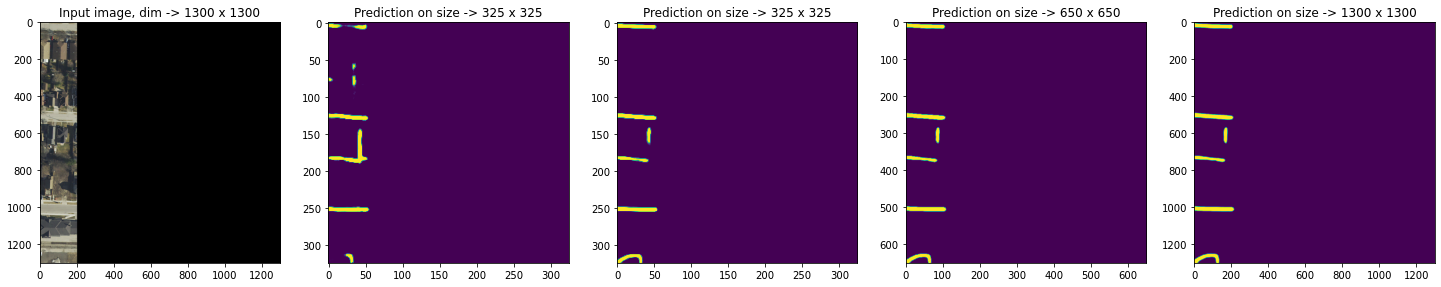

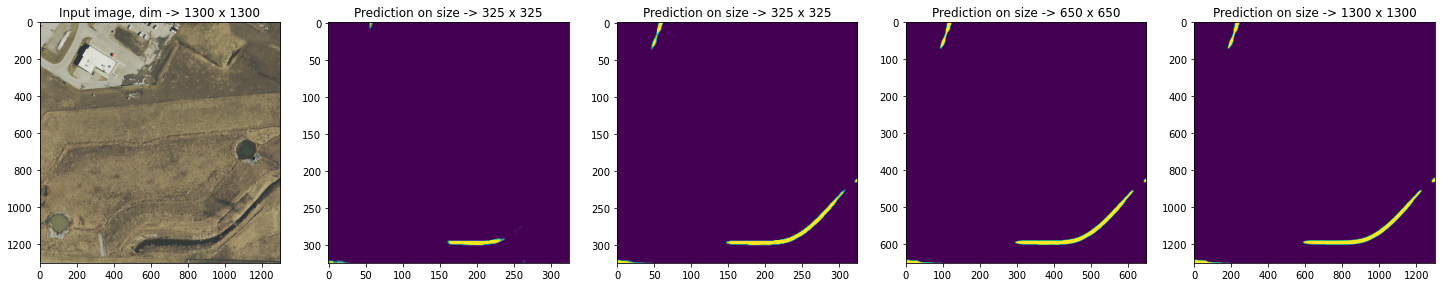

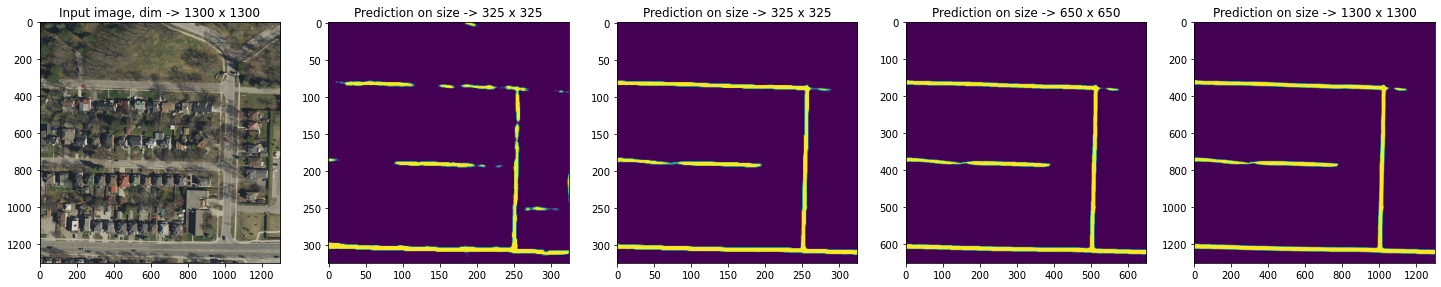

In [196]:
sample_dim = [1300, 1300]

for i in range(len(BGR_sample)):
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,25))

    ax1.imshow(cv2_to_plt(BGR_sample[i]))
    ax1.set_title('Input image, dim -> {} x {}'.format(sample_dim[0], sample_dim[1]))
    
    ax2.imshow((F.softmax(outputs[0], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax2.set_title('Prediction on size -> {} x {}'.format(325, 325))
    
    ax3.imshow((F.softmax(outputs[1], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax3.set_title('Prediction on size -> {} x {}'.format(325, 325))
    
    ax4.imshow((F.softmax(outputs[2], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax4.set_title('Prediction on size -> {} x {}'.format(650, 650))
    
    ax5.imshow((F.softmax(outputs[3], dim=1).data.cpu()[:, 1, :, :])[i,:,:])
    ax5.set_title('Prediction on size -> {} x {}'.format(1300, 1300))
    
    plt.show()